# Introduction
Many simulation games incorporate a trading element where players engage in the buying and selling of goods. Typically, players visit various producers that offer a specific set of goods at a low price and subsequently deliver these goods to different consumers willing to purchase them at a higher price. The natural objective in such scenarios is to maximize profit following a successful trading endeavor. This analysis focuses on Star Citizen, a space simulation game currently in development.

In Star Citizen, each outpost on planets/moons and space stations maintains a list of goods available for sale and purchase. For example, a mining outpost may sell various minerals while seeking to buy items like medical supplies. Frequently, the producing locations offer goods at a lower price, making a trading strategy viable. The strategic approach involves acquiring goods from these producing locations and selling them in major hubs such as space stations or cities. The ultimate goal is to determine the optimal producers and consumers to visit, along with the ideal quantities to purchase and sell.

# Motivation
Presently, there are available tools designed for identifying trade routes. However, these tools appear to face limitations in identifying routes that span across multiple locations while accommodating various types of cargo. Moreover, considering the current state of supply in the game, these existing tools seem incapable of factoring in the anticipated low supply of highly profitable goods. Therefore, by explicitly formulating the problem in the language of optimization, it is possible to address some of these issues.

# Problem Description
As Star Citizen operates within a space simulation, conventional "roads" are not a consideration. Each buyer/seller is directly accessible from every other buyer/seller via quantum jump. Quantum jumps occur in empty space, serving as means to navigate around obstacles. Generally, quantum jumping within a planetary system is swift, but jumping between planets and Lagrange points consumes a longer duration. At each quantum jump stop, a specific set of commodities is available for buying and selling at varying prices. Additionally, there are constraints on the limited demand and supply for each commodity, as well as a restriction on the amount of available cargo space.

Due to the finite supply/demand, it is impractical to revisit the same location multiple times on a single trade run. Consequently, each location should be visited at most once. While it is not mandatory for the player to start and end at the same location, it can be a desirable feature. Furthermore, there is no stipulation that the player must commence the trade route from a specific location. This implies that the trade route problem at hand is a variant of the Traveling Salesman Problem (TSP) with selective locations and trade operations.

# Time-Based Problem Formulation

To begin, we must establish the loss function $L(d, \theta)$. Let

$\theta = (B_{ilt}, S_{ilt}, D_{ilt}, P_{ilt})$, representing the modeled state of the world, where

$B_{ilt}$ = the price to purchase commodity $i$ at location $l$ during step $t$

$S_{ilt}$ = the price to sell commodity $i$ at location $l$ during step $t$

$D_{ilt}$ = the demand for commodity $i$ at location $l$ during step $t$

$P_{ilt}$ = the supply for commodity $i$ at location $l$ during step $t$

Furthermore, assume there are $N$ commodities, $C$ cargo space, $M$ locations, and a maximum of $T$ steps to consider. A virtual start location, denoted as 0, is introduced to account for an arbitrary starting point.

The chosen route can be expressed as

$d = (X_{ijt}, L_{ilt}, I_{ilt})$, where

$X_{ijt}$ = a binary variable indicating the player's movement from location i to location j at time t

$L_{ilt}$ = the intended amount of commodity $i$ to sell at location $l$ at time $t$

$I_{ilt}$ = the intended amount of commodity $i$ to buy at location $l$ at time $t$

It is crucial to note that valid routes confine the player to a single location at any given time. Moreover, the player engages in buying and selling goods exclusively at the current location. Lastly, due to the time required for commodities to refresh, each location can only be visited once per run.

Subsequently, the trade loss function is defined considering the state of the game. Let the cargo hold of commodity $i$ by time $t$ be

$H_{it}= \sum_{k}^{t} \sum_{l} min(I_{ilk}, P_{ilk}) - \sum_{k}^{t-1} \sum_{l} min(L_{ilk}, D_{ilk})$

Then, after keeping track of cargo holds $H$ of commodity $i$ at time $t$, assuming that the plan had respected constraints such as the max cargo hold,

$L(d, \theta) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} \min(P_{ilt}, I_{ilt})B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} \min(D_{ilt}, L_{ilt}, H_{it})S_{ilt}$

In essence, it represents the sum of money spent on actual purchases minus the sum of money made from actual sales.

## Ideal Loss

In an ideal scenario with an oracle providing perfect information, the decision rule can be tailored to purchase and sell within the observed supply and demand. Venturing beyond these parameters presents logistical challenges and hampers potential profit. A strategy that leaves goods unsold would necessitate a final cargo cleanup, introducing inconvenience. Deliberately leaving unmet demand or purchasing more than necessary would result in diminished profit. Therefore, under perfect information, the optimal decision rule aligns the supply and demand at each shop. This implies that $P_{ilt} \geq I_{ilt}$ and $D_{ilt} \geq L_{ilt}$, leading to the formulation:

$L(d, \theta) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} I_{ilt}B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} L_{ilt}S_{ilt}$

Given perfect information, where the decision is the route $d$, the risk $R(d, \theta) = L(d, \theta)$, and the Bayes risk $r(d) = E_{\theta}[R(d, \theta)]$.

Assuming that the state of the game is known at every step, $\theta$ would be fixed, and the expectation corresponds to the negative final profit.

## Realistic Loss

In practice, the planner cannot observe any information about the current state of the game. Thus, considering each route, \(d\), with the original loss function:

$L(d, \theta) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} \min(P_{ilt}, I_{ilt})B_{ilt} - \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} \min(D_{ilt}, L_{ilt}, H_{it})S_{ilt}$

Taking expectations as before, the Bayes risk becomes:

$r(d) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} E_\theta[\min(P_{ilt}, I_{ilt})]B_{ilt} - \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} E_\theta[\min(D_{ilt}, L_{ilt}, H_{it})]S_{ilt}$

Since the first minimum has only two terms,

$E_\theta[\min(P_{ilt}, I_{ilt})] = E_\theta[E[\min(P_{ilt}, I_{ilt}) | I(P_{ilt} \le I_{ilt})]]
 = I_{ilt}Pr(P_{ilt} > I_{ilt}) + E_{\theta}[P_{ilt} | P_{ilt} \le I_{ilt}]Pr(P_{ilt} \le I_{ilt})$

The inclusion of uncertainties poses an issue because the distributions for $P$ and $D$ has to be estimated, and it is probably not even going to be convex. Thus, for the problem to be efficiently solved, the Bayes risk cannot be used as the objective function out of the box. Instead, an alternative linear/quadratic objective function would be needed.

### Limiting Disappointments

In the realm of imperfect knowledge regarding the game's state, for any given sequence of location visits ${v_i}$ and purchasing commodities ${m_i}$ at each step $i$,
the actual profit of a route containing those visits may deviate from the optimal profit. The difference due to realistic supply and demand can be formalized.

Let $L'(d_{vm}, \theta)$ be the negative profit for the route $d$ visiting ${v_i}$ and purchasing commodities ${m_i}$, assuming ideal supply and demand,
and $L(d_{vm}, \theta)$ be the realized value for a route $d$ visiting ${v_i}$ and purchasing commodities ${m_i}$.
The difference in profit would be due to the state of the game. We can consider the routes $d_{vm}$ such that

$Pr(L(d_{vm}, \theta) - L'(d_{vm}, \theta) > \delta) < \epsilon$

for some $\epsilon$ and $\delta$ greater than 0.

Assuming that changes in price are negligible, the value of $L(d_{vm}, \theta) - L'(d_{vm}, \theta)$
comes down to $I_{ilt} - \min(P_{ilt}, I_{ilt})$ and $L_{ilt} - \min(D_{ilt}, L_{ilt})$ based on the previous sections. Note that the $L$ here is the
variable for the intended amounts of goods to sell.

Empirically, it is generally the case that high-value commodities are either in short supply at locations that sell them or have low demand at the locations that buy them. Hence, in those situations,
$I_{ilt} \geq P_{ilt}$ and $L_{ilt} \geq D_{ilt}$.

### Pessimistic Objective

In the scenario where no disappointments are desired, one can consider the limiting case:

$Pr(L(d_{vm}, \theta) = L'(d_{vm}, \theta)) < \epsilon$

Under this context, a pessimistic linear objective function can be optimized. We can focus solely on $d$ such that a profit of K is achieved. To further reduce $\epsilon$, the objective function can be set up to minimize the maximum amount of goods purchased and sold:

$C(r, \theta) = ||I||_\infty + ||L||_\infty$

After minimizing the amount of goods bought and sold, we can hope (and assume) that we have not exceeded the supply and demand. Then, the profit can be calculated as a linear function similar to the ideal condition:

$\text{(PL)} \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} L_{ilt}S_{ilt} - \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} I_{ilt}B_{ilt} \geq K$


#### Extension of the Pessimistic Loss

In the previous formulation, all commodities are treated equally, which can lead to a worse $\epsilon$.
Consider two commodities, A and B, where A generates more profit than B. However, both commodities generate enough profit to satisfy the constraint $K$ if a full load of either good is traded. In the case $T = 2, M = 2$, let $X$ be the amount of A bought and sold, and $Y$ be the amount of B. The optimal solution would have $X \geq Y$. Suppose that $X < Y$, then swapping the values of $X$ and $Y$, and decreasing $X$ would result in a lower maximum while making the same amount of profit.

Now, suppose B is always available to buy and sell in an amount exceeding the cargo size, but the supply of A is at 0 for 99% of the time. Then, for all $\delta$, trading only B fulfills $Pr(L'(d, \theta) - L(d, \theta) > \delta) < \epsilon$ for all $\epsilon$. However, such a route would never be generated since the optimizer would choose A over B.

This issue can be alleviated by assigning a weight to the buy and sell amount of each commodity, leading to the new objective function:

$C(r, \theta) = ||W_b \cdot I||_\infty + ||W_s \cdot L||_\infty$

where $W_b$ are the buy weights, $W_s$ are the sell weights, and $\cdot$ indicates term-by-term multiplication. By assigning weights according to the scarcity of the supply/demand, some distributional information can be captured by the pessimistic approach. Additionally, a simple weighting scheme would be to set the weights as the inverse of supply and demand for non-zero entries and zero otherwise. This would normalize the amount bought and sold as a percentage of supply and demand.


## Constraints

The constraints defining a valid route can be linearly formulated. Given the focus on the pessimistic loss, $D$ and $P$ are considered as the maximum supply/demand. The specific distribution of $D$ and $P$ becomes relevant when attempting to quantify the difference between theoretical and realistic loss.

### Path

(1) $ \forall i, t \geq 1, \sum\limits_j X_{ijt} \leq \min(1, \sum\limits_j X_{ji(t-1)}) $

(2) $ \forall t, \sum\limits_i \sum\limits_j X_{ijt} \leq 1 $

(3) $ \forall j, \sum\limits_i \sum\limits_t X_{ijt} \leq 1 $

(4) $ \sum\limits_j X_{0j0} = 1 $

These constraints ensure that the selected path aligns with logical travel scenarios:

Constraint (1) ensures that a path from i to j can be taken only when the player arrives at i in the previous step.

Constraint (2) ensures that the player travels only one path at each step.

Constraint (3) ensures that the player arrives at each location at most once.

Constraint (4) ensures that the player starts from the "start."


### Buying/Selling Locations

(5) $ \forall t, j, 3C\sum\limits_i X_{ijt} \geq \sum\limits_g I_{gjt} + \sum\limits_g L_{gjt} $

(6) $ \forall t, j, \sum\limits_g I_{gjt} + \sum\limits_g L_{gjt} \geq \sum\limits_i X_{ijt} $

These constraints guarantee that the player exclusively buys and sells at their current location:

Constraint (5) ensures that buying/selling any goods at location $j$ during time $t$ sets $\sum\limits_i X_{ijt}$ to 1, indicating that the player arrived at location $j$ before engaging in any activities there.

Constraint (6) ensures that if the player goes to a specific location, some action is taken there.


### Buying/Selling Amount

(7) $ \forall t, \sum\limits_{n=0}^t \sum\limits_i \sum\limits_g I_{gin} - \sum\limits_{n=0}^t \sum\limits_i \sum\limits_g L_{gin} \leq C $

(8) $ \sum\limits_{g,i}L_{gi0} \leq 0, \forall g, t \geq 1, \sum\limits_i L_{git} \leq \sum\limits_{n=0}^t \sum\limits_i I_{gin} - \sum\limits_{n=0}^{t-1} \sum\limits_i L_{gin} $

(9) $ \sum\limits_{t,g,i} I_{git} = \sum\limits_{t,g,i} L_{git} $

(10) $ \forall g, i, t, L_{git} \geq 0, I_{git} \geq 0 $

(11) $ \forall g, i, t, I_{git} \leq P_{git}, L_{git} \leq D_{git} $

These constraints ensure that the amounts bought and sold are legitimate. In particular,

(7) ensures that all purchases do not exceed the maximum cargo amount.

(8) ensures that the commodities sold are currently in possession.

(9) ensures that all goods bought will eventually be sold.

(10) ensures that it is impossible to purchase and sell less than 0 units of cargo.

(11) ensures that the decision rule selects only the actions that are within the maximum supply/demand.


## Simplifications

While the formulation accommodates varying maximum supply/demand at the same location during different steps, it is improbable that the game would exhibit such a degree of variation. Therefore, it is reasonable to assume that the maximum supply/demand remains constant across all time steps.


# Solving

The pessimistic formulation is implemented in Python using cvxpy. All the constraints are linear in form, and
there exists a linear formulation of the objective function. Thus, the problem falls under the category of Mixed Integer Programming (MIP).


## Preparing Data

The supply, demand, and price information is extracted from the SC Trade Tool. Subsequently, the information
was organized in a matrix format as specified in the problem formulation. Then, only the locations
and commodities from ArcCorp were extracted. Therefore, for this example, only intra-planetary trading
within ArcCorp is considered.


First, the shops info are read from a json file generated by a scraper that downloaded the data from SC Trade Tool.

In [1]:
import math
from typing import Iterable, Tuple, List, Dict

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from itertools import zip_longest
from itertools import product
from collections import namedtuple

For the purpose of testing, the shops are limited to the ones on ArcCorp. In addition, the more dangerous locations are filtered.

**Note: The data used here were taken from SC Trade Tool during version 3.18-3.19 update.**

In [2]:
Shop = namedtuple("Shop", "path buys sells")
Commodity = namedtuple("Commodity", "name price stock refresh")
shops = []
shop_blk = ["Stanton > microTech > Euterpe > Devlin Scrap & Salvage",
            "Stanton > ArcCorp > Wala > Samson & Son's Salvage Center"]
with open("shops.json", "r") as fp:
    temp = json.load(fp)
    for t in temp:
        path = t[0]

        if "Stanton > ArcCorp" not in path and "start" != path:
            continue
        if path in shop_blk:
            continue

        buy_temp = t[1]
        sell_temp = t[2]
        buys = [Commodity(*b) for b in buy_temp]
        sells = [Commodity(*s) for s in sell_temp]

        shops.append(Shop(path, buys, sells))

shops.insert(0, Shop("start", [], []))
print("Number of Shops: " + str(len(shops)))

Number of Shops: 17


Next, the shops are converted to matrix form, which can be consumed by the solver.

In [3]:
class RoutePlanner:

    def __init__(self, shops: Iterable[Shop]):
        # builds indices to quickly transfer in and out of matrix forms
        self.shops_idx = {s.path: i for i, s in enumerate(shops)}
        self.shops_rev_idx = {i: s.path for i, s in enumerate(shops)}
        self.commodities_idx = {}

        commodity_count = 0
        for s in shops:
            for b in s.buys:
                if b.name not in self.commodities_idx:
                    self.commodities_idx[b.name] = commodity_count
                    commodity_count = commodity_count + 1
            for sl in s.sells:
                if sl.name not in self.commodities_idx:
                    self.commodities_idx[sl.name] = commodity_count
                    commodity_count = commodity_count + 1

        self.commodities_rev_idx = {i: v for v, i in self.commodities_idx.items()}

        # Initializes the P, D, B, S matrices
        self.supply = np.zeros((len(self.commodities_idx), len(self.shops_idx)))
        self.demand = np.zeros((len(self.commodities_idx), len(self.shops_idx)))
        self.buy_price = np.zeros((len(self.commodities_idx), len(self.shops_idx)))
        self.sell_price = np.zeros((len(self.commodities_idx), len(self.shops_idx)))

        for s in shops:
            if s.path not in self.shops_idx:
                continue
            for b in s.buys:
                self.demand[self.commodities_idx[b.name], self.shops_idx[s.path]] = b.stock
                self.sell_price[self.commodities_idx[b.name], self.shops_idx[s.path]] = b.price
            for sl in s.sells:
                self.supply[self.commodities_idx[sl.name], self.shops_idx[s.path]] = sl.stock
                self.buy_price[self.commodities_idx[sl.name], self.shops_idx[s.path]] = sl.price

    def create_weights(self) -> Tuple:
        """
        Creates buy and sell weights according to the inverse demand and supply weighting scheme.
        :return: buy weights and sell weights as a tuple
        """
        buy_weight = np.divide(1, self.supply, out=np.zeros_like(self.supply), where=self.supply != 0)
        sell_weight = np.divide(1, self.demand, out=np.zeros_like(self.demand), where=self.demand != 0)
        return buy_weight, sell_weight

    def update_supply(self, good, location, amount):
        """
        updates the supply of good at a given location
        :param good: the name of the good
        :param location: the name of the location
        :param amount: the new amount of goods
        """
        if good not in self.commodities_idx:
            raise KeyError("%s not found" % good)
        if location not in self.shops_idx:
            raise KeyError("%s not found" % location)
        if amount < 0:
            raise ValueError("amount cannot be negative")
        good_idx = self.commodities_idx[good]
        location_idx = self.shops_idx[location]
        self.supply[good_idx, location_idx] = amount

    def update_demand(self, good, location, amount):
        """
        updates the demand of goods at a given location
        :param good: the name of the good
        :param location: the name of location
        :param amount: the new amount
        """
        if good not in self.commodities_idx:
            raise KeyError("%s not found" % good)
        if location not in self.shops_idx:
            raise KeyError("%s not found" % location)
        if amount < 0:
            raise ValueError("amount cannot be negative")
        good_idx = self.commodities_idx[good]
        location_idx = self.shops_idx[location]
        self.demand[good_idx, location_idx] = amount

## Coding the Problem

The pessimistic formulation is realized via cvxpy. Here, it is assumed that a C2 is used for
the trade run. Finally, the inverse weighing scheme
discussed before is applied.

In [4]:
TimeParameters = namedtuple("TimeParameters", ['C', 'K', 'X', 'I', 'L', 'Wb', 'Ws'])
RoutePath = namedtuple("RoutePath", ["start", "end", "buy", "sell"])
Transaction = namedtuple("Transaction", ["loc", "com", "amount"])


class TimeBasedPlanner(RoutePlanner):

    def __init__(self, shops: Iterable[Shop], solver: str=None, steps=2):
        """
        initialize the time based solver.
        :param shops: the list of shops to operate over
        :param solver: the name of the solver to use
        :param steps: the default number of steps (number of locations arrived at - 1)
        """
        RoutePlanner.__init__(self, shops)
        self._prev_T = -1
        self._prob = None
        self._params = None
        self.solver = solver
        self.steps = steps

    def find_route(self, cargo: int, min_profit: float, steps=None) -> Tuple[float, List[RoutePath]]:
        """
        Find the optimal route that minimizes the percentage of goods bought and sold while upholding a certain profit level
        :param cargo: the available cargo space
        :param min_profit: the minimum amount of profit to achieve
        :param steps: the number of steps to consider
        :return: a tuple containing the max percentage of goods bought or sold, and the route
        """
        if steps is None:
            steps = self.steps
        buy_weight, sell_weight = self._create_weights()
        if steps != self._prev_T:
            self._prob, self._params = self._formulate_problem(steps + 1)
            self._prev_T = steps
            self._params.Wb.value = buy_weight
            self._params.Ws.value = sell_weight
        self._params.C.value = cargo
        self._params.K.value = min_profit
        obj = self._prob.solve(solver=self.solver)

        # steps + 1 to account for the 'start' location
        routes = self._extract_routes(steps + 1, self._params.X, self._params.I, self._params.L)
        return obj, routes

    def _extract_transactions(self, array) -> List[Transaction]:
        """
        Converts the transactions from matrix form to list of Transaction
        :param array: the I or L matrix
        :return: list of transactions in the given matrix
        """
        non_zero = np.nonzero(array.value)
        items = []
        for i, idx in enumerate(non_zero[0]):
            col_idx = non_zero[1][i]
            amount = array[idx, col_idx].value
            commodity = self.commodities_rev_idx[idx]
            location = self.shops_rev_idx[col_idx]
            items.append(Transaction(location, commodity, amount))
        return items

    def _extract_routes(self, steps: int, path_mat, buy_mat, sell_mat) -> List[RoutePath]:
        """
        extracts the trade route from the optimization states
        :param steps: the number of steps to extract
        :param path_mat: the X matrices
        :param buy_mat: the I matrix
        :param sell_mat: the L matrix
        :return: list of paths in the route
        """
        paths = []
        for t in range(steps):
            non_zero = np.nonzero(path_mat[t].value)
            if len(non_zero[0]) == 0:
                break
            start_idx = non_zero[0][0]
            end_idx = non_zero[1][0]
            start_loc = self.shops_rev_idx[start_idx]
            end_loc = self.shops_rev_idx[end_idx]
            buy = self._extract_transactions(buy_mat[t])
            sell = self._extract_transactions(sell_mat[t])
            paths.append(RoutePath(start_loc, end_loc, buy, sell))
        return paths

    def _create_weights(self):
        """
        Creates the Wb and Ws weight matrix according to the inverse weighting scheme
        """
        buy_weight = np.divide(1, self.supply, out=np.zeros_like(self.supply), where=self.supply != 0)
        sell_weight = np.divide(1, self.demand, out=np.zeros_like(self.demand), where=self.demand != 0)
        return buy_weight, sell_weight

    def _formulate_problem(self, T:int) -> cp.Problem:
        """
        Sets up the optimization problem with T steps
        :param T: the number of steps
        :return: the optimization problem
        """
        C = cp.Parameter(nonneg=True)
        K = cp.Parameter(nonneg=True)
        M = len(self.shops_idx)
        N = len(self.commodities_idx)
        Wb = cp.Parameter((N, M), nonneg=True)
        Ws = cp.Parameter((N, M), nonneg=True)

        # Theta
        b = cp.Parameter((N, M), nonneg=True)
        s = cp.Parameter((N, M), nonneg=True)
        d = cp.Parameter((N, M), nonneg=True)
        p = cp.Parameter((N, M), nonneg=True)
        B = [b for _ in range(T)]
        S = [s for _ in range(T)]
        D = [d for _ in range(T)]
        P = [p for _ in range(T)]

        # r
        X = [cp.Variable((M, M), boolean=True) for _ in range(T)]
        L = [cp.Variable((N, M), nonneg=True) for _ in range(T)]
        I = [cp.Variable((N, M), nonneg=True) for _ in range(T)]

        # L(d(O), theta)
        objective = cp.Minimize(cp.maximum(cp.maximum(*[cp.max(cp.multiply(I[t], Wb)) for t in range(T)]),
                                           cp.maximum(*[cp.max(cp.multiply(L[t], Ws)) for t in range(T)])))

        constraints = []

        # Path Constraints
        # (1)
        for i in range(M):
            for t in range(1, T):
                c = cp.sum(X[t][i]) <= cp.minimum(1, cp.sum(X[t - 1][:, i]))
                constraints.append(c)

        # (2)
        for t in range(T):
            constraints.append(cp.sum(X[t]) <= 1)

        # (3)
        for j in range(M):
            constraints.append(
                sum([cp.sum(X[t][:, j]) for t in range(T)]) <= 1
            )

        # (4)
        constraints.append(cp.sum(X[0][0]) == 1)

        # Buy/Sell Location Constraints
        # (5)
        for t in range(T):
            for j in range(M):
                constraints.append(3 * C * cp.sum(X[t][:, j]) >=
                                   cp.sum(I[t][:, j]) + cp.sum(L[t][:, j]))

        # (6)
        for t in range(T):
            for j in range(M):
                constraints.append(cp.sum(I[t][:, j]) + cp.sum(L[t][:, j]) >=
                                   cp.sum(X[t][:, j]))

        # Buy/Sell Amount Constraints
        # (7)
        for t in range(T):
            constraints.append(
                sum([cp.sum(I[n]) for n in range(t)]) -
                sum([cp.sum(L[n]) for n in range(t)]) <= C
            )

        # (8)
        for g in range(N):
            for t in range(1, T):
                constraints.append(
                    cp.sum(L[t][g]) <= sum([cp.sum(I[n][g]) for n in range(t + 1)]) -
                    sum([cp.sum(L[n][g]) for n in range(t)])
                )

        constraints.append(cp.sum(L[0]) <= 0)

        # (9)
        constraints.append(
            sum([cp.sum(L[t]) for t in range(T)]) ==
            sum([cp.sum(I[t]) for t in range(T)])
        )

        # (10), (11)
        for t in range(T):
            constraints.append(
                I[t] <= P[t]
            )
            constraints.append(
                L[t] <= D[t]
            )

        # (PL)
        constraints.append(sum([cp.sum(cp.multiply(L[i], S[i])) for i in range(T)]) -
                           sum([cp.sum(cp.multiply(I[i], B[i])) for i in range(T)]) >= K)

        prob = cp.Problem(objective, constraints)

        b.value = np.array(self.buy_price)
        s.value = np.array(self.sell_price)
        d.value = np.array(self.demand)
        p.value = np.array(self.supply)

        return prob, TimeParameters(C, K, X, I, L, Wb, Ws)


def print_plan(routes):
    for path in routes:
        if len(path.buy) == 0 and len(path.sell) == 0:
            continue
        print("---------------------------------------------")
        print("Start: " + path.start)
        print("End: " + path.end)
        print("Buy:")
        for item in path.buy:
            print("\t%f units of %s" % (item.amount, item.com))
        print("Sell")
        for item in path.sell:
            print("\t%f units of %s" % (item.amount, item.com))

## Solutions of the problem


A trade off curve of the objective function vs minimum profit is shown below for 2 steps. As the minimum profit increases, the norm
increases at a faster rate. This is a sign that the solver is forced to
assign more units to a few lucrative commodities instead of spreading them out.

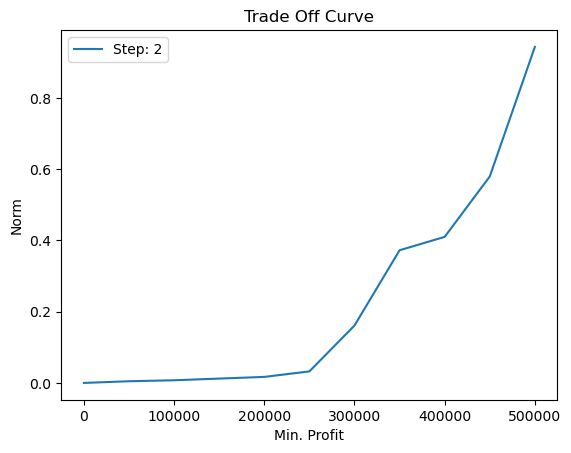

CPU times: user 6min 11s, sys: 13.9 s, total: 6min 24s
Wall time: 6min 26s


In [5]:
%%time

attempts = []
norm = []
time_planner = TimeBasedPlanner(shops, solver="SCIP")
steps = 2

for i in range(0, 500001, 50000):
    opt, _ = time_planner.find_route(69600, i, steps=steps)
    if opt == np.nan:
        break
    attempts.append(i)
    norm.append(opt)
trade_off_df = pd.DataFrame({"Min. Profit": attempts, "Norm": norm, "Step": [steps for _ in attempts]})

plt.plot(trade_off_df["Min. Profit"], trade_off_df["Norm"], label=f"Step: {steps}")
plt.legend()
plt.xlabel("Min. Profit")
plt.ylabel("Norm")
plt.title("Trade Off Curve")
plt.show()

An optimal route with 200K minimum profit with 3 steps is calculated below.

In [6]:
%%time
time_planner = TimeBasedPlanner(shops, solver="SCIP")
opt, routes = time_planner.find_route(69600, 200000, steps=3)
print_plan(routes)

---------------------------------------------
Start: start
End: Stanton > ArcCorp > Wala > Shady Glen Farms
Buy:
	1351.497967 units of Distilled Spirits
	68248.502033 units of Processed Food
Sell
---------------------------------------------
Start: Stanton > ArcCorp > Wala > Shady Glen Farms
End: Stanton > ArcCorp > Area18 > Admin
Buy:
	33787.449167 units of Audio-Visual Equipment
	33787.449167 units of Souvenirs
Sell
	1013.623475 units of Distilled Spirits
	66561.274859 units of Processed Food
---------------------------------------------
Start: Stanton > ArcCorp > Area18 > Admin
End: Stanton > ArcCorp > Baijini Point > Admin
Buy:
Sell
	270.299593 units of Distilled Spirits
	1687.227175 units of Processed Food
	33787.449167 units of Audio-Visual Equipment
	33787.449167 units of Souvenirs
---------------------------------------------
Start: Stanton > ArcCorp > Baijini Point > Admin
End: Stanton > ArcCorp > Lyria > Loveridge Mineral Reserve
Buy:
Sell
	67.574898 units of Distilled Spirit

# Two-Step Formulation Maximizing Profit

As an alternative to minimizing the norm to reduce disappointment, a different approach would be to constrain the amounts of goods purchased and sold.
Additionally, while the time-based formulation can provide a solution to the problem, it is slow to solve. To expedite the process,
a performance boost can be achieved by decomposing the
problem into two parts. First, a high-level plan that dictates where and what to purchase and sell is determined. Then, the
specific route that follows the high-level plan is drafted. Nevertheless, since the high-level plan does not take into account the
routes specifically, the two-stage approach may find suboptimal solutions.


## Step One: High Level Planning



In this step, the goal is to identify the set of shops and commodities to trade between. Additionally, extra
constraints and variables can be added to provide finer adjustments to the shops visited and commodities bought and sold.

### Variables

Assuming there are $M$ shops and $N$ commodities, let

$C$: the amount of cargo holds

$ML$: the maximum cost to travel between each pair of locations visited

$NS$: the number of stops

$Q_{ij}$: the maximum percentage of commodity $i$ to buy or sell at location $j$

$Wb_{ij}$: the weight for the purchase of commodity $i$ at location $j$ in the loss function. In this case, it is the inverse of the supply.

$Ws_{ij}$: the weight for the sale of commodity $i$ at location $j$ in the loss function. In this case, it is the inverse of the demand.

$B_{ij}$: the price to buy commodity $i$ at location $j$

$S_{ij}$: the price to sell commodity $i$ at location $j$

$D_{ij}$: the demand for commodity $i$ at location $j$

$P_{ij}$: the supply of commodity $i$ at location $j$

$R_{ij}$: the cost to travel from $i$ to $j$

$I_{ij}$: the amount of commodity $i$ to buy at $j$

$L_{ij}$: the amount of commodity $i$ to sell at $j$

$X_i$: indicator variable for whether location $i$ is visited in the plan

$A_{ij}$: upper triangular indicator variable matrix for whether the pair of locations $i$ and $j$ are both in the plan

Obviously, all the variables here are non-negative.



## Constraints

### Buy/Sell Constraints

(1) $ \forall i, \sum_{j} I_{ij} = \sum_{j} L_{ij} $

(2) $ \forall i, j, L_{ij}Ws_{ij} \leq Q_{ij} $

(3) $ \forall i, j, I_{ij}Wb_{ij} \leq Q_{ij} $

(4) $ \forall i, j, I_{ij} \leq P_{ij} $

(5) $ \forall i, j, L_{ij} \leq D_{ij} $

These constraints ensure that the high-level buys or sells appropriate amounts of commodities.

Constraint (1) ensures that the commodities bought equal the commodities sold.

Constraint (2) ensures that the amount of commodities sold is under the maximum specified percentage of demand, assuming the normalizing weighting scheme.

Constraint (3) ensures that the amount of commodities bought is under the maximum specified percentage of supply, assuming the normalizing weighting scheme.

Constraint (4) ensures that all purchases are within the supplies.

Constraint (5) ensures that all sales are within the demands.


### Cargo Constraints

(6) $ \forall j, \sum_{i} I_{ij} \leq C $

(7) $ \forall j, \sum_{i} L_{ij} \leq C $

(8) $ \forall j, \sum_{i} L_{ij} + \sum_{i} I_{ij} \leq 10CX_{j} $

These constraints ensure that the cargo space is handled correctly by the planner.

Constraint (6) ensures that all purchases are within the available cargo space.

Constraint (7) ensures that all sales are constrained by the available cargo space.

Constraint (8) ensures that the player must visit a location to buy and sell.


### Travel Constraints

(9) $ \forall i, j > i, 1 - A_{ij} \leq (1 - X_{i}) + (1 - X_{j}) $

(10) $ \forall i, j, A_{ij}R_{ij} \leq ML $

(11) $ \sum_{i} X_{i} = NS $

These constraints ensure that the plan stays within the expected number of shops and the amount of travel.

Constraint (9) ensures that the indicator variables $A$ are set correctly.

Constraint (10) ensures that the maximum pair-wise cost of travel is within the specified amount.

Constraint (11) ensures that the plan only considers routes with the specified number of stops.


## Objective Function

Since there are constraints in place to allow fine-grained control of maximum commodities, the standard profit objective can be maximized instead. However, it would not be readjusted the problem to use the pessimistic objective from the time formulation.

Maximize $C(r, \theta) = \sum_i \sum_j L_{ij} S_{ij} - \sum_i \sum_j I_{ij} B_{ij}$



Using the same data from before, the high level planner is applied to all the shops.

In [7]:
HighLevelPlan = namedtuple("HighLevelPlan", ['cost', 'revenue', 'buy', 'sell'])
EPSILON = 0.0001


def compute_travel_cost(paths: List[str], path_idx: Dict[str, int]):
    """
    Computes placeholder travel costs between locations.
    It performs string matching between the full path of the locations and
    sets the cost roughly as the depth of the full path tree - the level of the lowest common ancestor between two locations.
    :param paths: the list of locations to compute the cost for
    :param path_idx: the path index mapping to convert to matrix form
    :return: the R matrix
    """
    result = np.zeros((len(paths), len(paths)))
    max_level = -1
    for p in paths:
        p_pars = p.split(">")
        if len(p_pars) >= max_level:
            max_level = len(p_pars)

    for shop_a, shop_b in product(paths, paths):
        ix_a, ix_b = path_idx[shop_a], path_idx[shop_b]
        if shop_a == shop_b:
            result[ix_a, ix_b] = 0
        parts_a = shop_a.split(">")
        parts_b = shop_b.split(">")
        curr_level = max_level
        for a, b in zip_longest(parts_a, parts_b, fillvalue="-1"):
            if a.strip() != b.strip():
                result[ix_a, ix_b] = curr_level
                break
            curr_level = curr_level - 1
    return result


def build_idx(transactions: List[Transaction]) -> Tuple:
    """
    constructs all the index required from the shops and commodities that appeared in a given list of transactions
    :param transactions: the transactions to construct the indices from
    :return: a tuple of the shop index, the reverse shop index, commodity index, and the reverse commodity index
    """
    locations = set()
    commodities = set()
    shop_idx = {}
    shop_rev_idx = {}
    com_idx = {}
    com_rev_idx = {}
    for t in transactions:
        locations.add(t.loc)
        commodities.add(t.com)
    for i, p in enumerate(locations):
        shop_idx[p] = i
        shop_rev_idx[i] = p
    for i, p in enumerate(commodities):
        com_idx[p] = i
        com_rev_idx[i] = p

    return shop_idx, shop_rev_idx, com_idx, com_rev_idx


class TwoStagePlanner(RoutePlanner):

    def __init__(self, shops: Iterable[Shop], solver:str=None, ignore_dpp=None):
        """
        initializes the planner
        :param shops: the shops to operate over
        :param solver: the name of the solver
        :param ignore_dpp: whether to apply the DPP ruleset
        """
        RoutePlanner.__init__(self, shops)
        self._buy_weight, self._sell_weight = self.create_weights()
        self.init_solve = self._formulate_step_one()
        self._trv_c = compute_travel_cost([s.path for s in shops], self.shops_idx)
        self.solver = solver
        self._init_supply = np.array(self.supply)
        self.ignore_dpp = ignore_dpp
        self._init_demand = np.array(self.demand)

    def plan_stage_one(self, cargo: int, max_percent=0.2, max_commodity:Dict[str, float]=None, blk_locations:Iterable[str]=(),
                       max_com_loc:Dict[str, Dict[str, float]]=None, max_level=2, n_stop=3) -> Tuple[float, HighLevelPlan]:
        """
        creates the high level plan for the given configuration.
        :param cargo: the available cargo spaces
        :param max_percent: the maximum percentage of goods to buy and sell with respect to the demand and supply at a given location
        :param max_commodity: sets the maximum percentage at a commodity level
        :param blk_locations: sets the list of locations to blacklist
        :param max_com_loc: sets the maximum percentage at a commodity/location level
        :param max_level: sets the maximum travel cost between any pair of locations
        :param n_stop: sets the number of stops to make
        :return: a tuple consisting of the profit and the high level plan, or infinity and None if cannot be solved
        """
        self._init_basic(self.init_solve, cargo, max_percent=max_percent, max_commodity=max_commodity,
                         blk_locations=blk_locations, max_com_loc=max_com_loc)
        self.init_solve.param_dict["R"].value = self._trv_c
        self.init_solve.param_dict["ML"].value = max_level
        self.init_solve.param_dict["NS"].value = n_stop

        profit = self.init_solve.solve(solver=self.solver, ignore_dpp=self.ignore_dpp)
        if math.isfinite(profit):
            self.init_solve.var_dict["I"].value[np.where(self.init_solve.var_dict["I"].value < EPSILON)] = 0
            self.init_solve.var_dict["L"].value[np.where(self.init_solve.var_dict["L"].value < EPSILON)] = 0
            return profit, self._extract_plan(self.shops_rev_idx, self.commodities_rev_idx,
                                              self.init_solve.var_dict["I"], self.init_solve.var_dict["L"],
                                              self.init_solve.param_dict["S"],
                                              self.init_solve.param_dict["B"])
        return profit, None

    def _init_basic(self, problem: cp.Problem, cargo: int, max_percent=0.2, max_commodity:Dict[str, float]=None, blk_locations:Iterable[str]=(),
                    max_com_loc:Dict[str, Dict[str, float]]=None, com_idx:Dict[str, int]=None, shop_idx:Dict[str, int]=None, rows: List[int]=None, cols: List[int]=None):
        """
        Initializes the matrices for the given problem
        :param problem: the optimization problem
        :param cargo: the available cargo space
        :param max_percent: the maximum percentage of goods to buy and sell with respect to the demand and supply at a given location
        :param max_commodity: sets the maximum percentage at a commodity level
        :param blk_locations: sets the list of locations to blacklist
        :param max_com_loc: sets the maximum percentage at a commodity/location level
        :param com_idx: the commodity index
        :param shop_idx: the shop index
        :param rows: the rows of the matrices to subset if any
        :param cols: the columns of the matrices to subset if any
        """
        buy_price = self.buy_price
        sell_price = self.sell_price
        demand = self.demand
        supply = self.supply
        buy_weight = self._buy_weight
        sell_weight = self._sell_weight

        # Subsets rows and columns of matrices
        if rows is not None:
            buy_price = buy_price[rows, :]
            sell_price = sell_price[rows, :]
            demand = demand[rows, :]
            supply = supply[rows, :]
            buy_weight = buy_weight[rows, :]
            sell_weight = sell_weight[rows, :]

        if cols is not None:
            buy_price = buy_price[:, cols]
            sell_price = sell_price[:, cols]
            demand = demand[:, cols]
            supply = supply[:, cols]
            buy_weight = buy_weight[:, cols]
            sell_weight = sell_weight[:, cols]

        if com_idx is None:
            com_idx = self.commodities_idx
        if shop_idx is None:
            shop_idx = self.shops_idx

        problem.param_dict["B"].value = buy_price
        problem.param_dict["S"].value = sell_price
        problem.param_dict["D"].value = demand
        problem.param_dict["P"].value = supply
        problem.param_dict["Wb"].value = buy_weight
        problem.param_dict["Ws"].value = sell_weight
        problem.param_dict["C"].value = cargo

        # Progressively apply commodity percentage restrictions
        problem.param_dict["Q"].value = np.ones((len(com_idx), len(shop_idx))) * max_percent
        if max_commodity is not None:
            for k, percent in max_commodity.items():
                problem.param_dict["Q"].value[com_idx[k], :] = percent
        if max_com_loc is not None:
            for k, locs in max_com_loc.items():
                for l, amount in locs.items():
                    problem.param_dict["Q"].value[com_idx[k], shop_idx[l]] = amount

        # Apply location blacklist
        for loc in blk_locations:
            loc_idx = shop_idx[loc]
            problem.param_dict["D"].value[:, loc_idx] = 0
            problem.param_dict["P"].value[:, loc_idx] = 0

    def _extract_plan(self, shop_rev_idx: Dict[int, str], com_rev_idx: Dict[int, str], I, L, S, B):
        buy_transactions = []
        sell_transactions = []

        for com, loc in zip(*np.nonzero(I.value)):
            buy_transactions.append(Transaction(shop_rev_idx[loc],
                                                com_rev_idx[com],
                                                I.value[com, loc]))
        for com, loc in zip(*np.nonzero(L.value)):
            sell_transactions.append(Transaction(shop_rev_idx[loc],
                                                 com_rev_idx[com],
                                                 L.value[com, loc]))
        revenue = np.sum(np.multiply(L.value, S.value))
        cost = np.sum(np.multiply(I.value, B.value))
        return HighLevelPlan(cost, revenue, buy_transactions, sell_transactions)

    def _formulate_step_one(self):
        C = cp.Parameter(nonneg=True, name="C")
        ML = cp.Parameter(name="ML", nonneg=True)
        NS = cp.Parameter(name="NS", nonneg=True)
        M = len(self.shops_idx)
        N = len(self.commodities_idx)
        Q = cp.Parameter((N, M), nonneg=True, name="Q")
        Wb = cp.Parameter((N, M), nonneg=True, name="Wb")
        Ws = cp.Parameter((N, M), nonneg=True, name="Ws")

        B = cp.Parameter((N, M), nonneg=True, name="B")
        S = cp.Parameter((N, M), nonneg=True, name="S")
        D = cp.Parameter((N, M), nonneg=True, name="D")
        P = cp.Parameter((N, M), nonneg=True, name="P")
        R = cp.Parameter((M, M), nonneg=True, name="R")

        I = cp.Variable((N, M), nonneg=True, name="I")
        L = cp.Variable((N, M), nonneg=True, name="L")
        X = cp.Variable(M, boolean=True, name="X")
        A = cp.Variable((M, M), boolean=True, name="A")

        objective = cp.Maximize(cp.sum(cp.multiply(L, S)) - cp.sum(cp.multiply(I, B)))

        constraints = []

        # (1)
        constraints.append(
            cp.sum(I, axis=1) == cp.sum(L, axis=1)
        )

        # (2)
        constraints.append(
            cp.multiply(L, Ws) <= Q
        )

        # (3)
        constraints.append(
            cp.multiply(I, Wb) <= Q
        )

        # (4)
        constraints.append(I <= P)

        # (5)
        constraints.append(L <= D)

        # (6)
        constraints.append(
            cp.sum(I, axis=0) <= C
        )

        # (7)
        constraints.append(
            cp.sum(L, axis=0) <= C
        )

        # (8)
        constraints.append(
            cp.sum(L, axis=0) + cp.sum(I, axis=0) <= 10 * C * X
        )

        # (9)
        for i in range(M):
            for j in range(i + 1, M):
                constraints.append((1 - A[i, j]) <= (1 - X[i]) + (1 - X[j]))

        # (10)
        constraints.append(
            cp.multiply(A, R) <= ML
        )

        # (11)
        constraints.append(
            cp.sum(X) == NS
        )

        return cp.Problem(objective, constraints)

For demonstration, the RAFT cargo amount of 96 SCU is used, and some restrictions are placed on some high value goods.
Compared to the 3 step time based planner (visiting 4 locations), the high level planner took only around 18 seconds to solve the problem without restricting the shops.

In [8]:
%%time

cargo_size = 9600
shops = []
shop_blk = []

with open("shops.json", "r") as fp:
    temp = json.load(fp)
    for t in temp:
        path = t[0]

        buy_temp = t[1]
        sell_temp = t[2]
        buys = [Commodity(*b) for b in buy_temp]
        sells = [Commodity(*s) for s in sell_temp]

        shops.append(Shop(path, buys, sells))

ts_planner = TwoStagePlanner(shops, solver="SCIP", ignore_dpp=True)


def print_high_level_plan(plan):
    if plan is None:
        print("Infeasible/No Solution")
        return

    buy_consolidate = {}
    sell_consolidate = {}

    for t in plan.buy:
        if t.loc not in buy_consolidate:
            buy_consolidate[t.loc] = [t]
        else:
            buy_consolidate[t.loc].append(t)

    for t in plan.sell:
        if t.loc not in sell_consolidate:
            sell_consolidate[t.loc] = [t]
        else:
            sell_consolidate[t.loc].append(t)

    print("Revenue: %f, Cost: %f, Profit: %f" % (plan.revenue, plan.cost, plan.revenue - plan.cost))
    print("----------------------Purchases----------------------")
    for loc, trans in buy_consolidate.items():
        print("At: %s" % loc)
        for t in trans:
            print("\tBuy: %f units of %s" % (t.amount, t.com))
    print("----------------------Sell----------------------")
    for loc, trans in sell_consolidate.items():
        print("At: %s" % loc)
        for t in trans:
            print("\tSell: %f units of %s" % (t.amount, t.com))


profit, plan = ts_planner.plan_stage_one(cargo_size, n_stop=4, max_level=2, max_percent=1,
                                         max_commodity={"Laranite": 0.05, "Astatine": 0.1,
                                                        "Distilled Spirits": 0.2,
                                                        "E'tam": 0.3,
                                                        "WiDoW": 0.3,
                                                        "Neon": 0.3})
print_high_level_plan(plan)

Revenue: 740821.000000, Cost: 560423.000000, Profit: 180398.000000
----------------------Purchases----------------------
At: Stanton > Crusader > Daymar > Bountiful Harvest Hydroponics
	Buy: 3200.000000 units of Distilled Spirits
	Buy: 6400.000000 units of Revenant Tree Pollen
At: Stanton > Crusader > Daymar > ArcCorp Mining Area 141
	Buy: 1300.000000 units of Agricium
At: Stanton > Crusader > Daymar > Nuen Waste Management
	Buy: 1500.000000 units of E'tam
	Buy: 300.000000 units of Neon
	Buy: 5000.000000 units of Altruciatoxin
	Buy: 1500.000000 units of WiDoW
----------------------Sell----------------------
At: Stanton > Crusader > Daymar > ArcCorp Mining Area 141
	Sell: 3200.000000 units of Distilled Spirits
At: Stanton > Crusader > Daymar > Brio's Breaker Yard
	Sell: 1300.000000 units of Agricium
	Sell: 1500.000000 units of E'tam
	Sell: 300.000000 units of Neon
	Sell: 5000.000000 units of Altruciatoxin
	Sell: 1500.000000 units of WiDoW
At: Stanton > Crusader > Daymar > Nuen Waste Man

## Step Two: Route Planning


In this step, the goal is to take the high-level plan and come up with a route that traverses the locations in the plan while purchasing and selling goods. Note that although the higher-level planner can determine the location and commodity, since it does not take into account the actual order of arrival, there may be cases where executing the high-level plan would require visiting a location twice. Thus, to avoid this situation, the low-level planner would also need to have the ability to adjust the commodities bought and sold in the plan.

### Variables

Assuming there are $M$ shops and $N$ commodities in the high-level plan, let

$C$: the amount of cargo holds

$Q_{ij}$: the maximum percentage of commodity $i$ to buy or sell at location $j$

$Wb_{ij}$: the weight for purchasing commodity $i$ at location $j$ in the loss function, representing the inverse of the supply.

$Ws_{ij}$: the weight for selling commodity $i$ at location $j$ in the loss function, representing the inverse of the demand.

$B_{ij}$: the price to buy commodity $i$ at location $j$

$S_{ij}$: the price to sell commodity $i$ at location $j$

$D_{ij}$: the demand for commodity $i$ at location $j$

$P_{ij}$: the supply of commodity $i$ at location $j$

$R_{ij}$: the cost to travel from location $i$ to $j$

$I_{ij}$: the amount of commodity $i$ to buy at location $j$

$L_{ij}$: the amount of commodity $i$ to sell at location $j$

$MCF_{kij}$: an indicator variable to track the path to location $k$ through locations $i$ to $j$

$F_{kij}$: the amount of commodity $k$ moved from location $i$ to $j$

$X_{ij}$: an indicator for whether the player would travel from location $i$ to $j$

As before, all variables are non-negative. Additionally, artificial "start" and "end" locations are added with indices $M + 1$ and $M + 2$, respectively.


### Constraints

#### Path Constraints

(1) $\forall i = 1, 2, \ldots, M, M+1, \sum_{j} X_{ij} = 1$

(2) $\forall j = 1, 2, \ldots, M, M + 2, \sum_{i} X_{ij} = 1$

(3.1) $\sum_i X_{i(M + 2)} = 1$

(3.2) $\sum_j X_{(M + 2)j} = 0$

(3.3) $\sum_j X_{(M+1)j} = 1$

(3.4) $\sum_i X_{i(M+1)} = 0$

These constraints ensure that the planner accounts for traveling.

Constraint (1) ensures that the plan includes traveling from each location (excluding the end) to somewhere.

Constraint (2) ensures that every location (excluding the start) is visited from somewhere.

Constraint (3) ensures that the added start and end are handled correctly.



#### TSP Constraints (via MCF)

(4) $\forall k, i, j, X_{ij} \geq MCF_{kij}$

(5) $\forall k \neq M+1, \sum_{j} MCF_{k(M+1)j} = 1$

(6) $\forall k \neq M+1, \sum_{j} MCF_{kjk} = 1$

(7) $\forall k \neq M+1, j = 1, \ldots, k-1, k+1, \ldots, M, M+2, \sum_{i} MCF_{kij} = \sum_{i} [MCF_{kji} - MCF_{kj(M + 1)}]$

These constraints find a solution to the TSP problem.

Constraint (4) ensures that the path $i$ to $j$ is marked as traveled when going to location $k$ requires going through $i$ to $j$.
By the constraints on $X$, it also ensures that all the paths to each location $k$ are consistent with each other given that there's only one player.

Constraint (5) ensures that the travel plan starts from the start.

Constraint (6) ensures that the last step to location $k$ is indeed at $k$.

Constraint (7) ensures that excluding the start, for any location $k$, if the player visits any intermediate location $j$, then the next step on the path starts from $j$.


#### Buy/Sell/Cargo Constraints

(8) $\forall k, i, j, 10CX_{ij} \geq F_{kij}$

(9) $\forall i, \sum_{j} \sum_{j} F_{kij} \leq C$

(10) $\forall k, j, \sum_{i} F_{kji} - \sum_{i} F_{kij} = I_{kj} - L_{kj}$

(11) $\forall i, j, L_{ij}Ws_{ij} \leq Q_{ij}$

(12) $\forall i, j, I_{ij}Wb_{ij} \leq Q_{ij}$

(13) $\forall i, j, I_{ij} \leq P_{ij}$

(14) $\forall i, j, L_{ij} \leq D_{ij}$

These constraints account for the purchase and sale behaviors of the planner.

Constraint (8) ensures that all the commodity flows are consistent with the locations visited.

Constraint (9) ensures that all the commodity flows are within the cargo hold.

Constraint (10) ensures that changes in commodity flow at location $j$ are due to the purchase and sale at location $j$.

Constraints (11)-(14) control for the quantity as in stage 1.


### Objective

The second stage also aims to maximize profit, but with an added penalty for travel costs, as the route is explicitly involved.

$
\text{maximize } C(r, \theta) = \sum_i \sum_j L_{ij} S_{ij} - \sum_i \sum_j I_{ij} B_{ij} - \lambda \sum_{i} \sum_{j} X_{ij}R_{ij}
$

Here, $\lambda$ represents the penalty factor for travel costs.



### Standalone Second Stage

While the second stage can be utilized to solve the entire problem from start to finish, solving the Traveling Salesman Problem (TSP) with SC-style trading can be challenging, particularly with a large number of locations, resulting in extended solution times. Consequently, the first stage is introduced to mitigate the complexity by reducing the number of locations under consideration. Moreover, this formulation serves as an alternative to the time-based approach, offering variations in the implementation. For insights into performance considerations and additional formulations, refer to [Compact Formulations of the Steiner Traveling Salesman Problem and Related Problems](https://arxiv.org/pdf/1203.3854.pdf).


In [9]:
class TwoStagePlanner(RoutePlanner):

    def __init__(self, shops: Iterable[Shop], solver:str=None, ignore_dpp=None):
        """
        initializes the planner
        :param shops: the shops to operate over
        :param solver: the name of the solver
        :param ignore_dpp: whether to apply the DPP ruleset
        """

        RoutePlanner.__init__(self, shops)
        self._buy_weight, self._sell_weight = self.create_weights()
        self.init_solve = self._formulate_step_one()
        self._trv_c = compute_travel_cost([s.path for s in shops], self.shops_idx)
        self.solver = solver
        self._init_supply = np.array(self.supply)
        self.ignore_dpp = ignore_dpp
        self._init_demand = np.array(self.demand)

    def plan_stage_one(self, cargo:int, max_percent=0.2, max_commodity:Dict[str, float]=None, blk_locations:Iterable[str]=(),
                       max_com_loc:Dict[str, Dict[str, float]]=None, max_level=2, n_stop=3) -> Tuple[float, HighLevelPlan]:
        """
        creates the high level plan for the given configuration.
        :param cargo: the available cargo spaces
        :param max_percent: the maximum percentage of goods to buy and sell with respect to the demand and supply at a given location
        :param max_commodity: sets the maximum percentage at a commodity level
        :param blk_locations: sets the list of locations to blacklist
        :param max_com_loc: sets the maximum percentage at a commodity/location level
        :param max_level: sets the maximum travel cost between any pair of locations
        :param n_stop: sets the number of stops to make
        :return: a tuple consisting of the profit and the high level plan, or infinity and None if cannot be solved
        """

        self._init_params(self.init_solve, cargo, max_percent=max_percent, max_commodity=max_commodity,
                          blk_locations=blk_locations, max_com_loc=max_com_loc)
        self.init_solve.param_dict["R"].value = self._trv_c
        self.init_solve.param_dict["ML"].value = max_level
        self.init_solve.param_dict["NS"].value = n_stop

        profit = self.init_solve.solve(solver=self.solver, ignore_dpp=self.ignore_dpp)
        if math.isfinite(profit):
            self.init_solve.var_dict["I"].value[np.where(self.init_solve.var_dict["I"].value < EPSILON)] = 0
            self.init_solve.var_dict["L"].value[np.where(self.init_solve.var_dict["L"].value < EPSILON)] = 0
            return profit, self._extract_plan(self.shops_rev_idx, self.commodities_rev_idx,
                                              self.init_solve.var_dict["I"], self.init_solve.var_dict["L"],
                                              self.init_solve.param_dict["S"],
                                              self.init_solve.param_dict["B"])
        return profit, None

    def plan_refinement(self, plan, cargo, max_percent=0.2, max_commodity=None, blk_locations=(),
                        max_com_loc=None, travel_weight=1e-3) -> Tuple[float, List[RoutePath]]:
        """

        :param plan: the HighLevelPlan
        :param cargo: the available cargo spaces
        :param max_percent: the maximum percentage of goods to buy and sell with respect to the demand and supply at a given location
        :param max_commodity: sets the maximum percentage at a commodity level
        :param blk_locations: sets the list of locations to blacklist
        :param max_com_loc: sets the maximum percentage at a commodity/location level
        :param travel_weight: the weight assigned to the travel cost penalty
        :return: a tuple consisting of the profit and the route, or infinity and None if cannot be solved
        """
        shop_idx, shop_rev_idx, com_idx, com_rev_idx = build_idx([t for t in plan.buy] +
                                                                 [t for t in plan.sell])

        if max_commodity is not None:
            max_commodity = {k: v for k, v in max_commodity.items() if k in com_idx}

        blk_locations = [l for l in blk_locations if l in shop_idx]

        if max_com_loc is not None:
            temp = {}
            for k, locs in max_com_loc.items():
                if k not in com_idx:
                    continue
                temp[k] = {}
                for l, amount in locs.items():
                    if l not in shop_idx:
                        continue
                    temp[k][l] = amount

            max_com_loc = temp

        refinement_prob = self._formulate_refinement(n_locs=len(shop_idx), n_coms=len(com_idx),
                                                     lambda_weight=travel_weight)

        shop_selector = [self.shops_idx[shop_rev_idx[i]] for i in range(len(shop_idx))]
        com_selector = [self.commodities_idx[com_rev_idx[i]] for i in range(len(com_idx))]
        self._init_params(refinement_prob, cargo, max_percent=max_percent, max_commodity=max_commodity,
                          blk_locations=blk_locations,
                          max_com_loc=max_com_loc, com_idx=com_idx, shop_idx=shop_idx, rows=com_selector,
                          cols=shop_selector)

        refinement_prob.param_dict["R"].value = self._cherry_pick_travel(plan, shop_idx)
        profit = refinement_prob.solve(solver=self.solver)
        if math.isfinite(profit):
            refinement_prob.var_dict["I"].value[np.where(refinement_prob.var_dict["I"].value < EPSILON)] = 0
            refinement_prob.var_dict["L"].value[np.where(refinement_prob.var_dict["L"].value < EPSILON)] = 0
            return profit, self._extract_route(refinement_prob.var_dict["X"], refinement_prob.var_dict["I"],
                                               refinement_prob.var_dict["L"], shop_rev_idx,
                                               com_rev_idx)
        return profit, None

    def _cherry_pick_travel(self, plan, new_shop_idx):
        """
        Selects a sub-matrix from the travel cost matrix given a plan
        :param plan: the HighLevelPlan
        :param new_shop_idx: the smaller shop index
        :return: the new cost matrix
        """
        transactions = [t for t in plan.buy] + [t for t in plan.sell]
        locations = {t.loc for t in transactions} | {t.loc for t in transactions}
        travel_cost_idx = [self.shops_idx[l] for l in locations]
        new_travel_cost_idx = [new_shop_idx[l] for l in locations]
        cost_idx = zip(travel_cost_idx, new_travel_cost_idx)
        result = np.zeros((len(new_shop_idx), len(new_shop_idx)))
        for (i, ip), (j, jp) in product(cost_idx, cost_idx):
            result[ip, jp] = self._trv_c[i, j]
        return result

    def _init_params(self, problem: cp.Problem, cargo: int, max_percent=0.2, max_commodity:Dict[str, float]=None, blk_locations:Iterable[str]=(),
                    max_com_loc:Dict[str, Dict[str, float]]=None, com_idx:Dict[str, int]=None, shop_idx:Dict[str, int]=None, rows: List[int]=None, cols: List[int]=None):
        """
        Initializes the matrices for the given problem
        :param problem: the optimization problem
        :param cargo: the available cargo space
        :param max_percent: the maximum percentage of goods to buy and sell with respect to the demand and supply at a given location
        :param max_commodity: sets the maximum percentage at a commodity level
        :param blk_locations: sets the list of locations to blacklist
        :param max_com_loc: sets the maximum percentage at a commodity/location level
        :param com_idx: the commodity index
        :param shop_idx: the shop index
        :param rows: the rows of the matrices to subset if any
        :param cols: the columns of the matrices to subset if any
        """
        buy_price = self.buy_price
        sell_price = self.sell_price
        demand = self.demand
        supply = self.supply
        buy_weight = self._buy_weight
        sell_weight = self._sell_weight

        if rows is not None:
            buy_price = buy_price[rows, :]
            sell_price = sell_price[rows, :]
            demand = demand[rows, :]
            supply = supply[rows, :]
            buy_weight = buy_weight[rows, :]
            sell_weight = sell_weight[rows, :]

        if cols is not None:
            buy_price = buy_price[:, cols]
            sell_price = sell_price[:, cols]
            demand = demand[:, cols]
            supply = supply[:, cols]
            buy_weight = buy_weight[:, cols]
            sell_weight = sell_weight[:, cols]

        if com_idx is None:
            com_idx = self.commodities_idx
        if shop_idx is None:
            shop_idx = self.shops_idx

        problem.param_dict["B"].value = buy_price
        problem.param_dict["S"].value = sell_price
        problem.param_dict["D"].value = demand
        problem.param_dict["P"].value = supply
        problem.param_dict["Wb"].value = buy_weight
        problem.param_dict["Ws"].value = sell_weight
        problem.param_dict["C"].value = cargo
        problem.param_dict["Q"].value = np.ones((len(com_idx), len(shop_idx))) * max_percent
        if max_commodity is not None:
            for k, percent in max_commodity.items():
                problem.param_dict["Q"].value[com_idx[k], :] = percent
        if max_com_loc is not None:
            for k, locs in max_com_loc.items():
                for l, amount in locs.items():
                    problem.param_dict["Q"].value[com_idx[k], shop_idx[l]] = amount
        for loc in blk_locations:
            loc_idx = shop_idx[loc]
            problem.param_dict["D"].value[:, loc_idx] = 0
            problem.param_dict["P"].value[:, loc_idx] = 0

    def _extract_plan(self, shop_rev_idx, com_rev_idx, I, L, S, B):
        buy_transactions = []
        sell_transactions = []

        for com, loc in zip(*np.nonzero(I.value)):
            buy_transactions.append(Transaction(shop_rev_idx[loc],
                                                com_rev_idx[com],
                                                I.value[com, loc]))
        for com, loc in zip(*np.nonzero(L.value)):
            sell_transactions.append(Transaction(shop_rev_idx[loc],
                                                 com_rev_idx[com],
                                                 L.value[com, loc]))
        revenue = np.sum(np.multiply(L.value, S.value))
        cost = np.sum(np.multiply(I.value, B.value))
        return HighLevelPlan(cost, revenue, buy_transactions, sell_transactions)

    def _extract_route(self, X, I, L, rev_shop_idx:Dict[int, str], rev_com_idx:Dict[int, str]):
        cur_idx = np.nonzero(X.value[-2, :])[0][0]
        final_routes = []

        cur_start = "start"
        working_dest = ""
        working_buy = []
        working_sell = []
        while cur_idx != X.value.shape[0] - 1:
            cur_end = rev_shop_idx[cur_idx]
            new_route = cur_end != working_dest
            if new_route:
                working_dest = cur_end
                working_buy = []
                working_sell = []

            for com in np.nonzero(I.value[:, cur_idx])[0]:
                working_buy.append(Transaction(rev_shop_idx[cur_idx],
                                               rev_com_idx[com],
                                               I.value[com, cur_idx]))
            for com in np.nonzero(L.value[:, cur_idx])[0]:
                working_sell.append(Transaction(rev_shop_idx[cur_idx],
                                                rev_com_idx[com],
                                                L.value[com, cur_idx]))
            if new_route:
                final_routes.append(RoutePath(cur_start, working_dest, working_buy, working_sell))
            cur_start = cur_end
            cur_idx = np.nonzero(X.value[cur_idx, :])[0][0]
        return final_routes

    def _formulate_step_one(self):
        C = cp.Parameter(nonneg=True, name="C")
        ML = cp.Parameter(name="ML", nonneg=True)
        NS = cp.Parameter(name="NS", nonneg=True)
        M = len(self.shops_idx)
        N = len(self.commodities_idx)
        Q = cp.Parameter((N, M), nonneg=True, name="Q")
        Wb = cp.Parameter((N, M), nonneg=True, name="Wb")
        Ws = cp.Parameter((N, M), nonneg=True, name="Ws")

        B = cp.Parameter((N, M), nonneg=True, name="B")
        S = cp.Parameter((N, M), nonneg=True, name="S")
        D = cp.Parameter((N, M), nonneg=True, name="D")
        P = cp.Parameter((N, M), nonneg=True, name="P")
        R = cp.Parameter((M, M), nonneg=True, name="R")

        I = cp.Variable((N, M), nonneg=True, name="I")
        L = cp.Variable((N, M), nonneg=True, name="L")
        X = cp.Variable(M, boolean=True, name="X")
        A = cp.Variable((M, M), boolean=True, name="A")

        objective = cp.Maximize(cp.sum(cp.multiply(L, S)) - cp.sum(cp.multiply(I, B)))

        constraints = []

        # (1)
        constraints.append(
            cp.sum(I, axis=1) == cp.sum(L, axis=1)
        )

        # (2)
        constraints.append(
            cp.multiply(L, Ws) <= Q
        )

        # (3)
        constraints.append(
            cp.multiply(I, Wb) <= Q
        )

        # (4)
        constraints.append(I <= P)

        # (5)
        constraints.append(L <= D)

        # (6)
        constraints.append(
            cp.sum(I, axis=0) <= C
        )

        # (7)
        constraints.append(
            cp.sum(L, axis=0) <= C
        )

        # (8)
        constraints.append(
            cp.sum(L, axis=0) + cp.sum(I, axis=0) <= 10 * C * X
        )

        # (9)
        for i in range(M):
            for j in range(i + 1, M):
                constraints.append((1 - A[i, j]) <= (1 - X[i]) + (1 - X[j]))

        # (10)
        constraints.append(
            cp.multiply(A, R) <= ML
        )

        # (11)
        constraints.append(
            cp.sum(X) == NS
        )

        return cp.Problem(objective, constraints)

    def _formulate_refinement(self, n_locs, n_coms, lambda_weight=0.001):
        B = cp.Parameter((n_coms, n_locs), nonneg=True, name="B")
        S = cp.Parameter((n_coms, n_locs), nonneg=True, name="S")
        D = cp.Parameter((n_coms, n_locs), nonneg=True, name="D")
        P = cp.Parameter((n_coms, n_locs), nonneg=True, name="P")
        R = cp.Parameter((n_locs, n_locs), nonneg=True, name="R")
        Q = cp.Parameter((n_coms, n_locs), nonneg=True, name="Q")
        Wb = cp.Parameter((n_coms, n_locs), nonneg=True, name="Wb")
        Ws = cp.Parameter((n_coms, n_locs), nonneg=True, name="Ws")
        C = cp.Parameter(nonneg=True, name="C")

        MCF = [cp.Variable((n_locs + 2, n_locs + 2), nonneg=True) for _ in
               range(n_locs + 2)]
        F = [cp.Variable((n_locs, n_locs), nonneg=True) for _ in range(n_coms)]
        X = cp.Variable((n_locs + 2, n_locs + 2), boolean=True, name="X")
        I = cp.Variable((n_coms, n_locs), nonneg=True, name="I")
        L = cp.Variable((n_coms, n_locs), nonneg=True, name="L")

        objective = cp.Maximize(
            cp.sum(cp.multiply(L, S)) - cp.sum(cp.multiply(I, B)) - lambda_weight * cp.sum(cp.multiply(X[:-2, :-2], R)))

        constraints = []

        # (1)
        constraints.append(
            cp.sum(X[:-1, :], axis=1) == 1
        )

        # (2)
        constraints.append(
            cp.sum(X[:, :-2], axis=0) == 1
        )

        # (3)
        constraints.append(cp.sum(X[:, -1]) == 1)
        constraints.append(cp.sum(X[-1, :]) == 0)
        constraints.append(cp.sum(X[-2, :]) == 1)
        constraints.append(cp.sum(X[:, -2]) == 0)

        k_range = list(range(0, n_locs + 2))
        k_range.remove(n_locs)

        # (4)
        for flow in MCF:
            constraints.append(X >= flow)

        # (5)
        for k in k_range:
            constraints.append(
                cp.sum(MCF[k][n_locs, :]) == 1
            )

        # (6)
        for k in k_range:
            constraints.append(
                cp.sum(MCF[k][:, k]) == 1
            )

        # (7)
        for k in k_range:
            j_range = list(range(0, n_locs))
            j_range.append(n_locs + 1)
            j_range.remove(k)
            for j in j_range:
                constraints.append(
                    cp.sum(MCF[k][:, j]) ==
                    cp.sum(MCF[k][j, :]) - MCF[k][j, n_locs]
                )

        # (8)
        for flow in F:
            constraints.append(10 * C * X[:-2, :-2] >= flow)

        # (9)
        agg_flow = sum(F)
        constraints.append(
            cp.sum(agg_flow, axis=1) <= C
        )

        # (10)
        for g, flow in enumerate(F):
            for j in range(n_locs):
                constraints.append(
                    cp.sum(flow[j, :]) - cp.sum(flow[:, j]) == I[g, j] - L[g, j]
                )

        # (11)
        constraints.append(I <= P)
        # (12)
        constraints.append(L <= D)
        # (13)
        constraints.append(
            cp.multiply(L, Ws) <= Q
        )
        # (14)
        constraints.append(
            cp.multiply(I, Wb) <= Q
        )

        return cp.Problem(objective, constraints)


Then, using second stage, it only took around 1.75 seconds to find spepcific route once the high level plan is found.

In [10]:
%%time

ts_planner = TwoStagePlanner(shops, solver="SCIP", ignore_dpp=True)
profit, route = ts_planner.plan_refinement(plan, cargo_size, max_percent=1,
                                           max_commodity={"Laranite": 0.05, "Astatine": 0.1,
                                                          "Distilled Spirits": 0.2,
                                                          "E'tam": 0.3,
                                                          "WiDoW": 0.3,
                                                          "Neon": 0.3})
print_high_level_plan(plan)
print_plan(route)
print(f"Profit (with travel deduction): {profit}")

Revenue: 740821.000000, Cost: 560423.000000, Profit: 180398.000000
----------------------Purchases----------------------
At: Stanton > Crusader > Daymar > Bountiful Harvest Hydroponics
	Buy: 3200.000000 units of Distilled Spirits
	Buy: 6400.000000 units of Revenant Tree Pollen
At: Stanton > Crusader > Daymar > ArcCorp Mining Area 141
	Buy: 1300.000000 units of Agricium
At: Stanton > Crusader > Daymar > Nuen Waste Management
	Buy: 1500.000000 units of E'tam
	Buy: 300.000000 units of Neon
	Buy: 5000.000000 units of Altruciatoxin
	Buy: 1500.000000 units of WiDoW
----------------------Sell----------------------
At: Stanton > Crusader > Daymar > ArcCorp Mining Area 141
	Sell: 3200.000000 units of Distilled Spirits
At: Stanton > Crusader > Daymar > Brio's Breaker Yard
	Sell: 1300.000000 units of Agricium
	Sell: 1500.000000 units of E'tam
	Sell: 300.000000 units of Neon
	Sell: 5000.000000 units of Altruciatoxin
	Sell: 1500.000000 units of WiDoW
At: Stanton > Crusader > Daymar > Nuen Waste Man

# Discussion

In the absence of specific data on supply and demand information, the pessimistic loss can serve as a solid starting point for designing a trade route that aims to minimize the impact of shortages. With sufficient data, utilizing a more explicit formulation may result in increased profits over time. In a straightforward scenario where only one type of commodity is present, minimizing the maximum is equivalent to reducing the amount of goods purchased, consequently minimizing the probability of encountering shortages or over-supply.

In more complex situations, the minimized maximum still acts as an upper bound on the quantity of goods, leading to an upper limit on $\epsilon$. Indeed, it seems likely that the optimal solution under the pessimistic formulation minimizes $\epsilon$ under a certain distribution of supply and demand. If the L-infinity norm is replaced with the L-2 norm, it appears to be equivalent to imposing a normal prior on the potential state space, where the supply and demand of each commodity are independent and identically distributed (i.i.d.) and follow $N(0, \sigma^2)$ for some constant sigma.

From a practical standpoint, for a small number of shops, the time-based formulation presented here can identify optimal solutions, either by minimizing the maximum or maximizing profits. For a larger number of shops, the two-stage formulation may yield sub-optimal routes, but it can solve the problem more quickly.
